<h1><center>IE 313 Time Series Analysis: Code Implementation Assignment 2</center></h1>

### <div align="right">Nguyen Minh Duc (20202026) <br> Code adapted from Prof. Sungil Kim</div>

<h1>Table of Contents<span class="tocSkip"></span></h1>

[1. Library load](#Library-load)

[2. Data load and pre-processing](#Data-load)

[3. Test for stationarity](#Test-for-stationarity)

[4. Transformation and Checking the Stationarity](#Transformation-and-Checking-the-Stationarity)

[5. Estimation for ARIMA model order](#Estimation-for-ARIMA-model-order)

[6. Residual Analysis](#Residual-Analysis)

[7. Forecasting with our model](#Forecasting-with-our-model)

<h2>Library load<h2>

install the required packages using pip
* Install using pip : `pandas`, `scipy`, `matplotlib`, `statsmodels`,`pmdarima`

In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pmdarima as pm
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima


In [2]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf, pacf
from datetime import datetime
from scipy import stats
from scipy.stats import boxcox
import statsmodels.tsa as smt


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

<h2>Data load<h2>

<h3> The sample data 'Samsung_close.csv' is the daily closing stock price of Samsung from 2021-01 to 2022-10.<h3>

In [3]:
df = pd.read_csv('Samsung_close.csv')
df
df['Date'] = pd.to_datetime(df['Date']) # To convert dtype column 'Date'
df = df.set_index('Date')
df.head()

,Close
Date,
2021-01-04,83000
2021-01-05,83900
2021-01-06,82200
2021-01-07,82900
2021-01-08,88800


In [4]:
df.rename(columns={'Close':'value'}, inplace=True) # To convert column name
df.head()

,value
Date,
2021-01-04,83000
2021-01-05,83900
2021-01-06,82200
2021-01-07,82900
2021-01-08,88800


In [5]:
df.index #check dtype of index, it should be 'datetime64[ns]'

DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15',
               ...
               '2022-09-27', '2022-09-28', '2022-09-29', '2022-09-30',
               '2022-10-04', '2022-10-05', '2022-10-06', '2022-10-07',
               '2022-10-11', '2022-10-12'],
              dtype='datetime64[ns]', name='Date', length=438, freq=None)

In [6]:
check_missing_date = df.reindex(pd.date_range(start = '2021-01-04', end = '2022-10-12' )).isnull().all(1)
check_missing_date[check_missing_date == True]

2021-01-09    True
2021-01-10    True
2021-01-16    True
2021-01-17    True
2021-01-23    True
              ... 
2022-10-02    True
2022-10-03    True
2022-10-08    True
2022-10-09    True
2022-10-10    True
Length: 209, dtype: bool

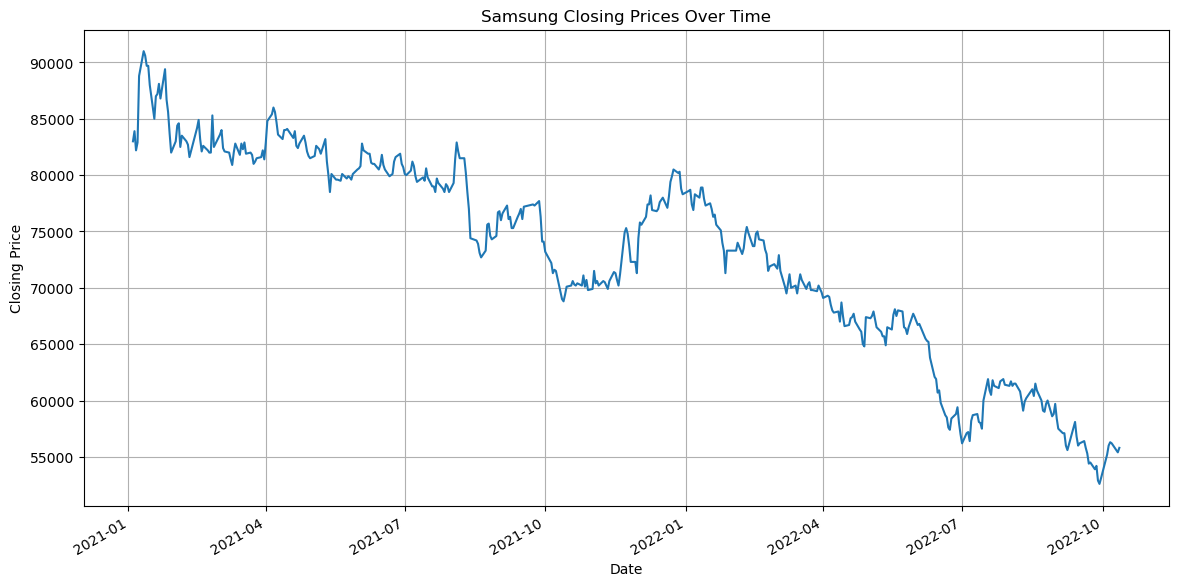

In [7]:
plt.figure(figsize=(14, 7))
df['value'].plot(title="Samsung Closing Prices Over Time", grid=True)
plt.ylabel('Closing Price')
plt.show()

**Preceed with time-series decomposition of the data.**

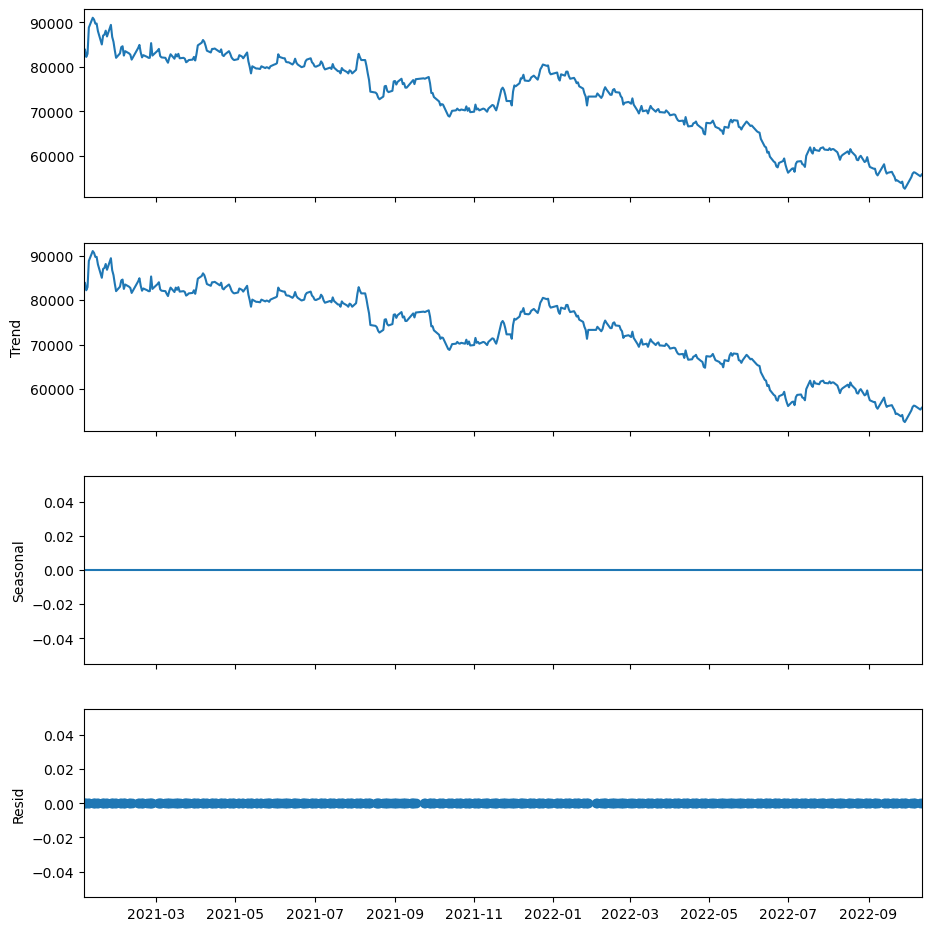

In [8]:
decomposition= sm.tsa.seasonal_decompose(df, model='additive', period=1)

ax = decomposition.plot()
ax.set_size_inches(10,10)

plt.show()


**From above we can clearly see that our data is having an decreasing trend.**

<h3>Test for stationarity<h3>

**There is another way to check the stationarity of the time series data.**

**Check whether your data is stationary or not using ACF, PACF distribution.**

In [9]:
# time-series analysis plots

def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        stats.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

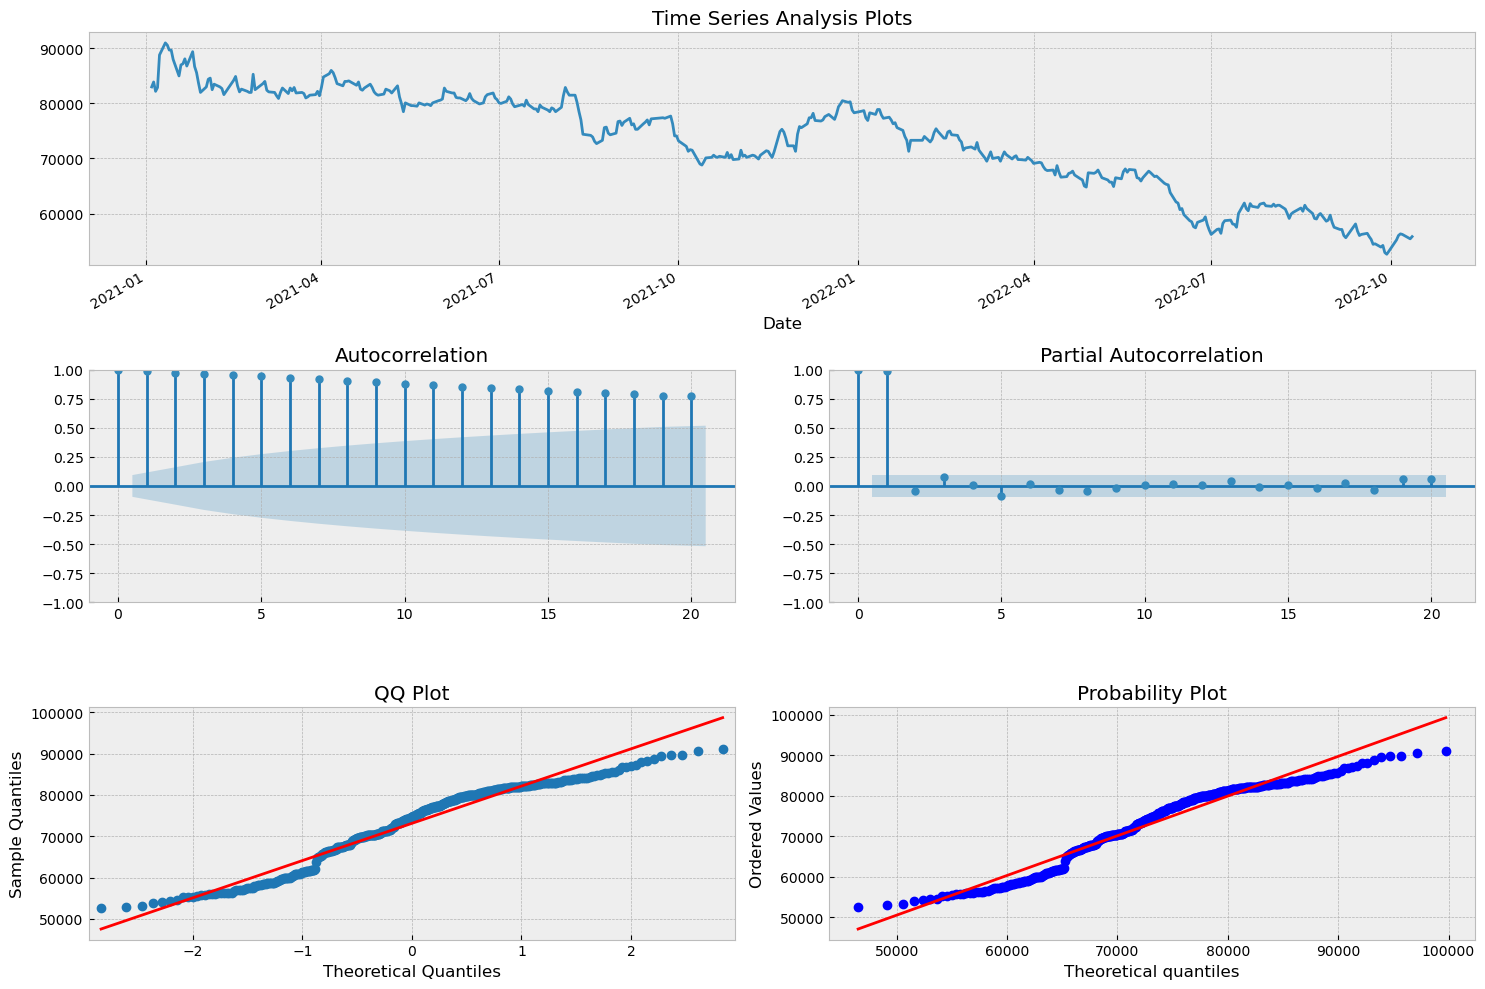

In [10]:
raw_data = tsplot(df['value'], lags=20)

**We can estimate that the raw data are non-stationary by seeing that they have ACF positive autocorrelation and PACF are gradually decreasing.**

**Also, PCAF(1) is large**

**We need to make it stationary by transformation.**

<h3>Transformation and Checking the Stationarity<h3>

<h3>First-Differencing<h3>

**We can use first-difference method to remove trend.**

In [11]:
#1st diffrence
diff_df = df['value'].diff(periods=1).iloc[1:]

print('Raw data')
print(df)

print('After 1st difference')
print(diff_df)

Raw data
            value
Date             
2021-01-04  83000
2021-01-05  83900
2021-01-06  82200
2021-01-07  82900
2021-01-08  88800
...           ...
2022-10-05  56000
2022-10-06  56300
2022-10-07  56200
2022-10-11  55400
2022-10-12  55800

[438 rows x 1 columns]
After 1st difference
Date
2021-01-05     900.0
2021-01-06   -1700.0
2021-01-07     700.0
2021-01-08    5900.0
2021-01-11    2200.0
               ...  
2022-10-05     800.0
2022-10-06     300.0
2022-10-07    -100.0
2022-10-11    -800.0
2022-10-12     400.0
Name: value, Length: 437, dtype: float64


<Axes: xlabel='Date'>

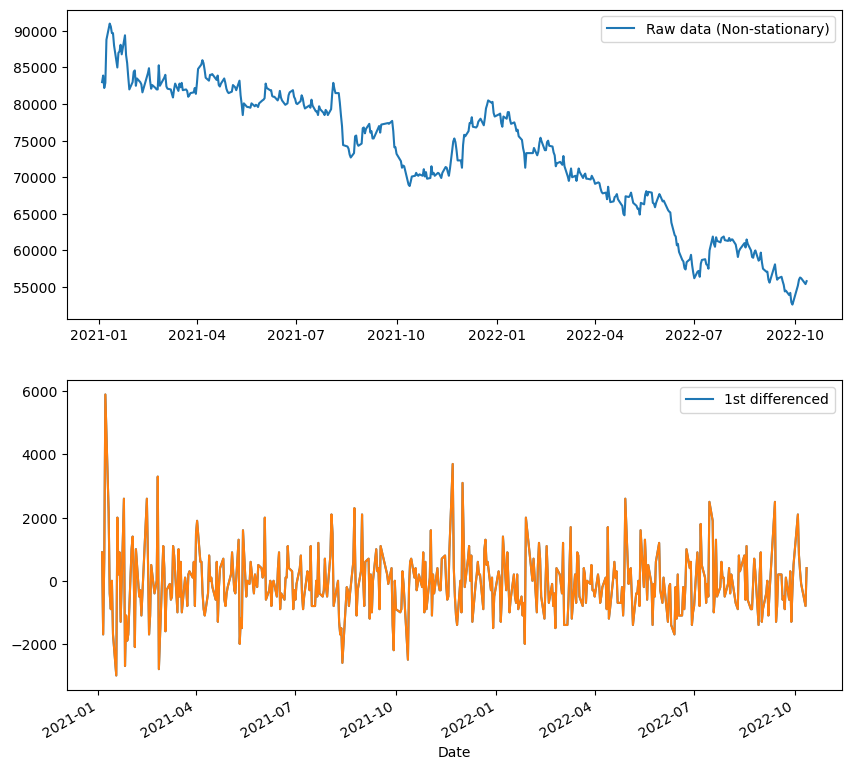

In [12]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(211)
ax1.plot(df['value'])
ax1.legend(['Raw data (Non-stationary)'])

ax2 =plt.subplot(212)
ax2.plot(diff_df)
ax2.legend(['1st differenced'])

diff_df.plot()

**After first-differencing, it looks quite stationary compared with the original data.**

**To make sure that the data have become stationary through the 1st differencing, we use the ADF (Augmented Dickey Fuller) test.**

* The null hypothesis (H0) of the Augmented Dickkey Fuller Test is "the data does not have stationarity", and the alternative hypothesis (H1) is "the data has stationarity".


* If the ADF statistic is greater than critical value, it means that the data is non-stationary, and if it is less than critical value, it means that the data is stationary.


* If the p-value is greater than 0.05, it means that the data is non-stationary, and if it is less than 0.05, it means that the data is stationary.

In [13]:
# ADF test

adf_test = adfuller(diff_df)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %20.20f' % adf_test[1])

ADF Statistic: -15.746659
Critical Values @ 0.05: -2.87
p-value: 0.00000000000000000000


**The ADF statistic is less than critical values. Also, the p-value is nearly 0 and it is less than 0.05.**

**After 1st differencing, our data looks stationary. Then, let's try 2nd differencing to our data.**

<h3> Second differencing<h3>

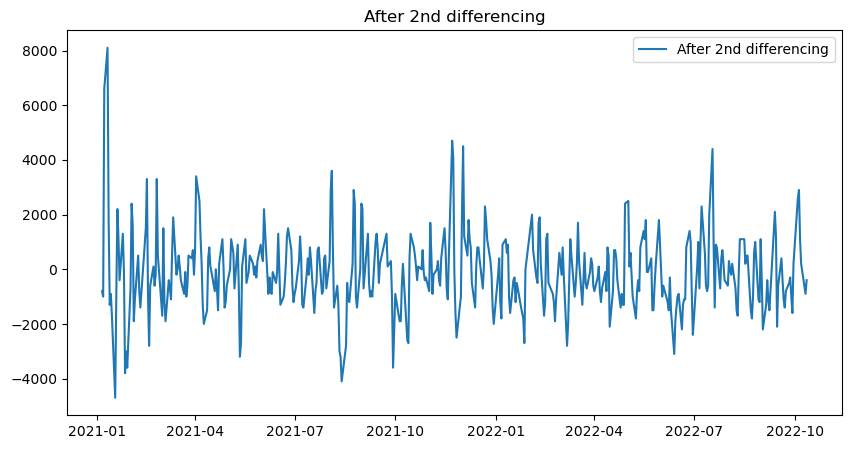

In [14]:
#2nd difference
diff_2_df = df['value'].diff(periods=2).iloc[2:]

plt.figure(figsize=(10,5))
plt.plot(diff_2_df, label='After 2nd differencing')
plt.legend(loc='best')
plt.title('After 2nd differencing')
plt.show()

In [15]:
diff_2_df.head()

Date
2021-01-06    -800.0
2021-01-07   -1000.0
2021-01-08    6600.0
2021-01-11    8100.0
2021-01-12    1800.0
Name: value, dtype: float64

In [16]:
# ADF test

adf_test = adfuller(diff_2_df)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %20.20f' % adf_test[1])

ADF Statistic: -5.497216
Critical Values @ 0.05: -2.87
p-value: 0.00000211020642639007


**Therefore, the p-value is 2.4083609623608695e-10, less than 0.05. So it is stationary.**


<h3> Logarithm<h3>

**Next, let's use a log transformation method to keep the variation width of our data constant.**

In [17]:
df_log = np.log(df['value'])

#1st differencing with logarithm
diff_df_log = df_log.diff(periods=1).iloc[1:]

#2nd differencing with logarithm
diff_2_df_log = df_log.diff(periods=2).iloc[2:]


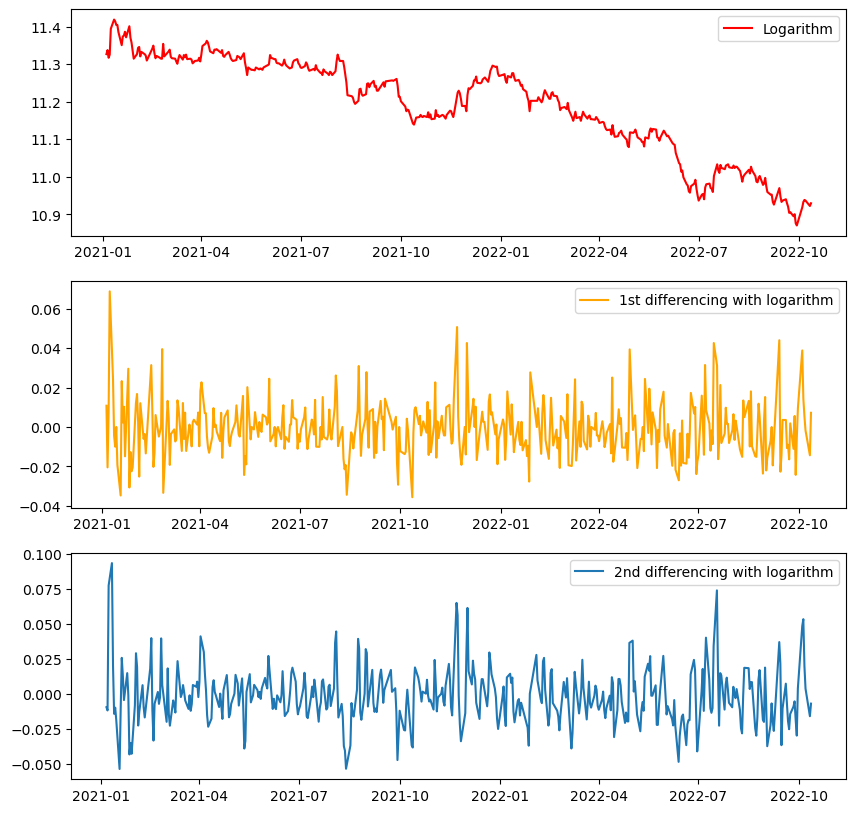

In [18]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(311)
ax1.plot(df_log, color='red')
ax1.legend(['Logarithm'])


ax2 = plt.subplot(312)
ax2.plot(diff_df_log, color='orange')
ax2.legend(['1st differencing with logarithm'])

ax3 =plt.subplot(313)
ax3.plot(diff_2_df_log)
ax3.legend(['2nd differencing with logarithm'])


In [19]:
# ADF test

adf_test = adfuller(diff_df_log)
adf_test_ = adfuller(diff_2_df_log)

print('---1st differencing with logarithm---')
print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %20.20f' % adf_test[1])


print('\n---2nd differencing with logarithm---')
print('ADF Statistic: %f' % adf_test_[0])
print('Critical Values @ 0.05: %.2f' % adf_test_[4]['5%'])
print('p-value: %20.20f' % adf_test_[1])

---1st differencing with logarithm---
ADF Statistic: -15.839707
Critical Values @ 0.05: -2.87
p-value: 0.00000000000000000000

---2nd differencing with logarithm---
ADF Statistic: -5.305520
Critical Values @ 0.05: -2.87
p-value: 0.00000533332433027996


**When we differenced our data after log transformation, both results of ADF test seem to stationary.**

***As an example, we will use the <U>1st difference with logarithm</U> in the model.***

In [20]:
chosen_df = df_log
diff_chosen_df = diff_df_log

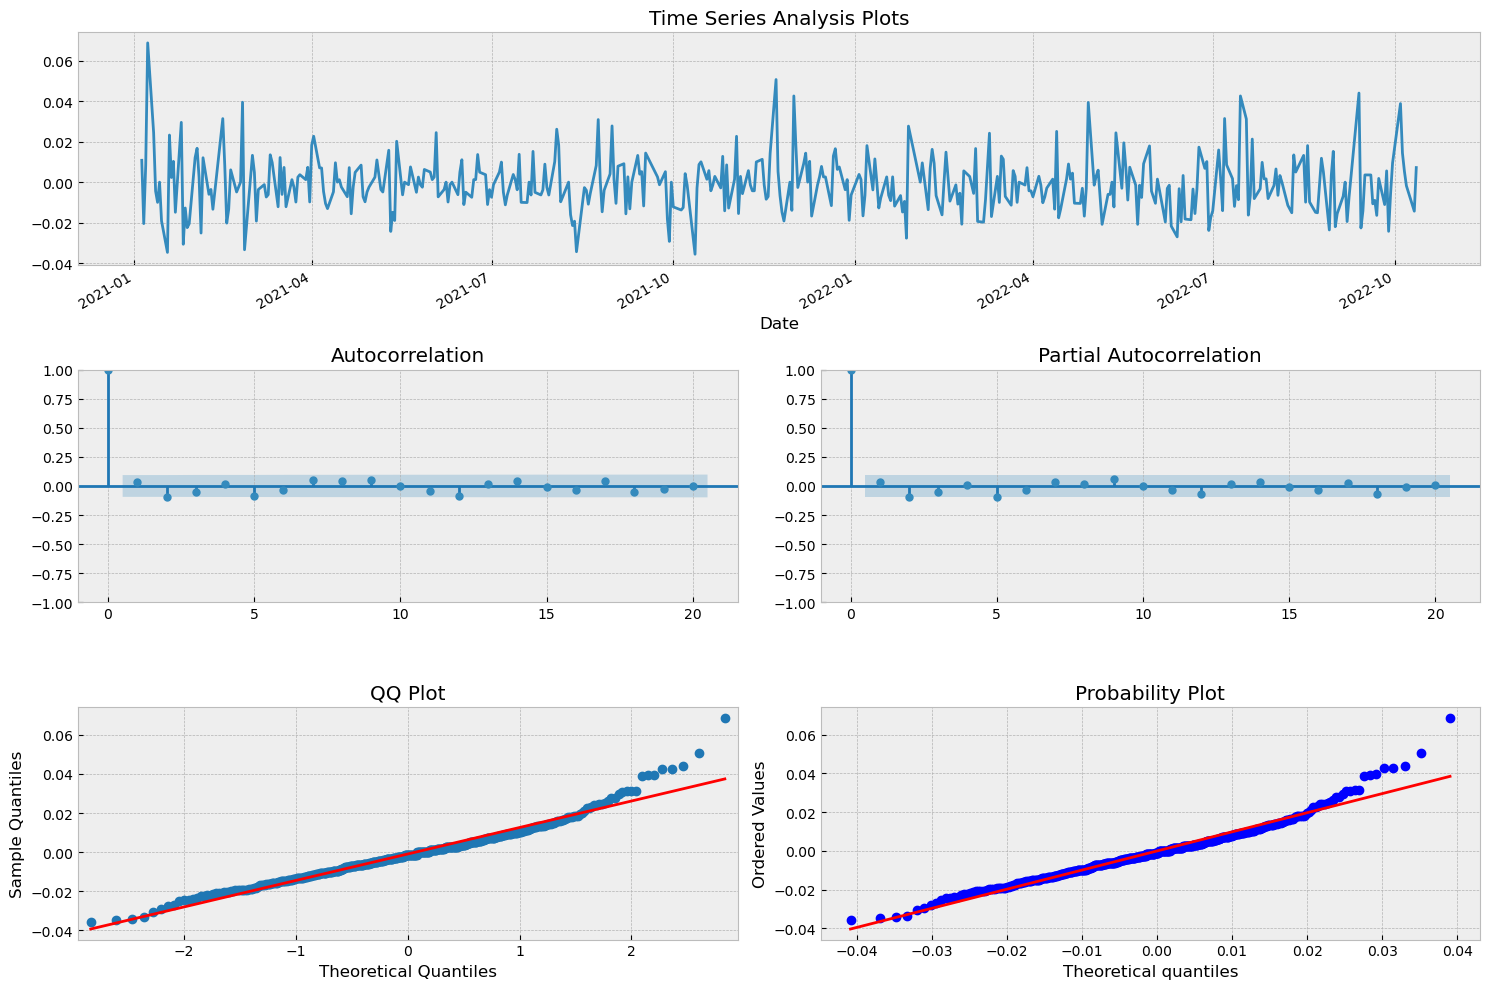

In [21]:
#check ACF, PACF of 1st difference with logarithm

diff_2_plot= tsplot(diff_chosen_df, lags=20)

**Looking the partial autocorrelation function (PACF) plot, it looks like *sine wave*. Most of them are in the blue boundary. It suggest p=0, which is the order of AR(p) model.**

**However, when looking at the autocorrelation function (ACF) plot, they are also well within the blue boundary, hence, there is a clear cut off lag q=0, which is the order of MA(q) model.**

| Model            | ACF                | PACF  |
|------------------|--------------------|------ |
|MA(q)             |cut off after lag q |Die out|
|AR(p)             |Die out             |Cut off after lag p|
|ARMA(p,q)         |Die out (after q-p) |Die out (after q-p)|


> Die out : exponentially or sin function

* **Example of clearly showing the lag in which ACF and PACF are cut off**

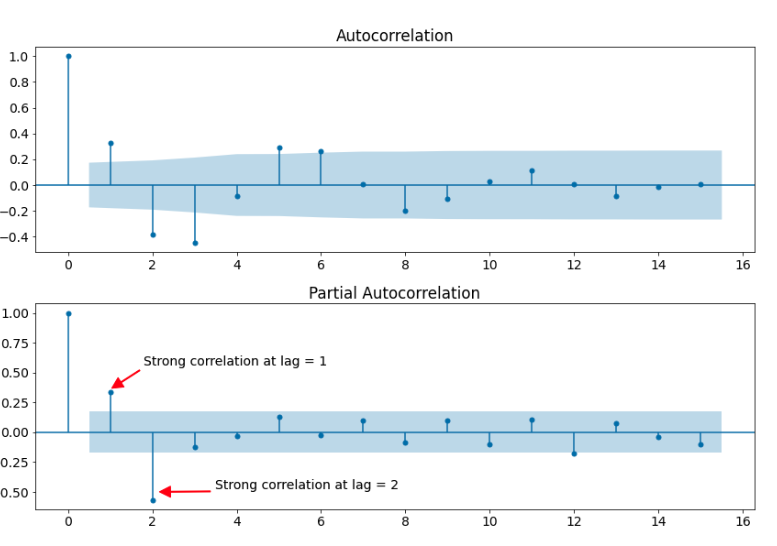

**Therefore, it is ambiguous to determine the order of the AR or MA models by looking only at the ACF and PACF plot of the 1st difference with logarithm data.**

**For now, we will try the AR(1) and MA(1) models and then use the auto_arima function, which finds the optimal order of the models.**

<h3>Estimation for ARIMA model order<h3>

In [22]:
model = sm.tsa.arima.ARIMA(chosen_df, order= (0, 1, 0)).fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  438
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1259.428
Date:                Mon, 30 Oct 2023   AIC                          -2516.857
Time:                        14:51:01   BIC                          -2512.777
Sample:                             0   HQIC                         -2515.247
                                - 438                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0002    8.7e-06     21.113      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):               142.56
Prob(Q):                              0.44   Pr

**The p-value of ar.L1 is lower than 0.05, and AIC is  -971.619**

**Then, let's try AR(1) model.**

In [23]:
# In ARIMA (p,d,q) model, we try AR(1).
model = sm.tsa.arima.ARIMA(chosen_df, order= (1,1,0)).fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  438
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1259.805
Date:                Mon, 30 Oct 2023   AIC                          -2515.610
Time:                        14:51:01   BIC                          -2507.450
Sample:                             0   HQIC                         -2512.390
                                - 438                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0415      0.041      1.015      0.310      -0.039       0.122
sigma2         0.0002   8.69e-06     21.106      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

**The p value is still lower than 0.05.**

**Plus, AIC and BIC values are lower than the first model.  We need to find the model parameters p,q with the smallest AIC.**


**We can search the optimal parameter p,d,q by auto_arima function.**

**As we distinguish once for the p,q order from 0 to 5, we will specify d=1.**

In [24]:
# The combination is for ARIMA order.

model = pm.auto_arima(chosen_df, d=1,
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2516.824, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2515.422, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2515.551, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2516.857, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2513.413, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.195 seconds


**The optimal p, d , q are 0, 1, 0.**

**Then, we create ARIMA model with p=0, d=1, q=0.**

In [25]:
# create model
model = sm.tsa.arima.ARIMA(chosen_df, order= (0, 1, 0))
results = model.fit()

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  438
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1259.428
Date:                Mon, 30 Oct 2023   AIC                          -2516.857
Time:                        14:51:02   BIC                          -2512.777
Sample:                             0   HQIC                         -2515.247
                                - 438                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0002    8.7e-06     21.113      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):               142.56
Prob(Q):                              0.44   Pr

**All p-values are greater than 0.05. However, AIC and BIC is lowest compared with above results.**

<h3>Residual Analysis<h3>

| Test      |Good Fit                | 
|------------------|--------------------|
|Standardized residual           |There are no obvious patterns in the residuals|
|Histogram plus kde estimate          |The KDE curve should be very similar to the normal distribution           |
|Normal Q-Q        |Most of the data points should lie on the straight line |
|Correlogram| 95% of correlations for lag greater than zero should not be significant|

**Now, let's inspect the residuals of the model.**

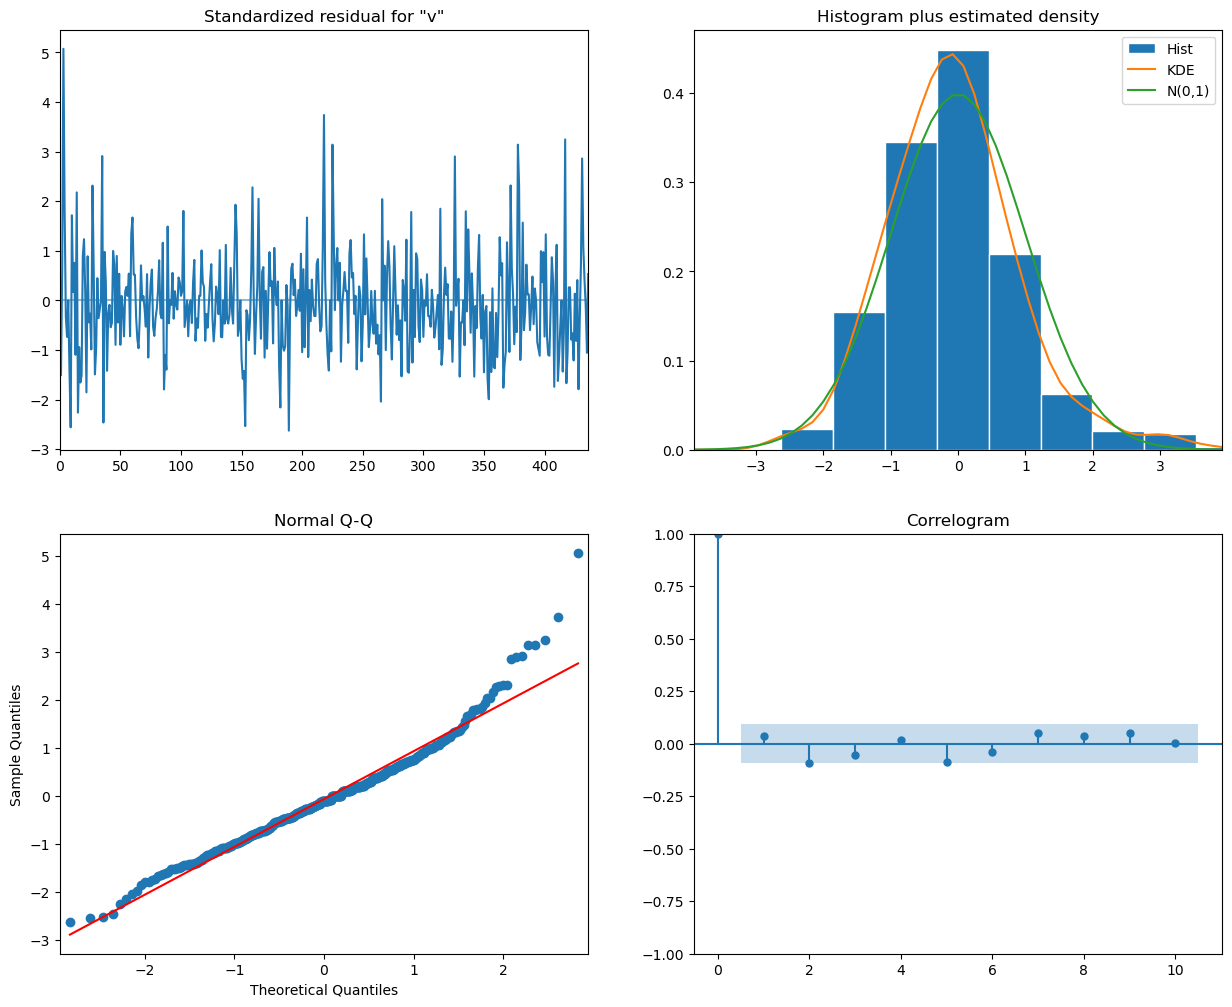

In [26]:
results.plot_diagnostics(figsize=(15,12))
plt.show()

In [27]:
# create model
model = sm.tsa.arima.ARIMA(chosen_df, order= (1, 1, 0))
results = model.fit()

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  438
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1259.805
Date:                Mon, 30 Oct 2023   AIC                          -2515.610
Time:                        14:51:03   BIC                          -2507.450
Sample:                             0   HQIC                         -2512.390
                                - 438                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0415      0.041      1.015      0.310      -0.039       0.122
sigma2         0.0002   8.69e-06     21.106      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

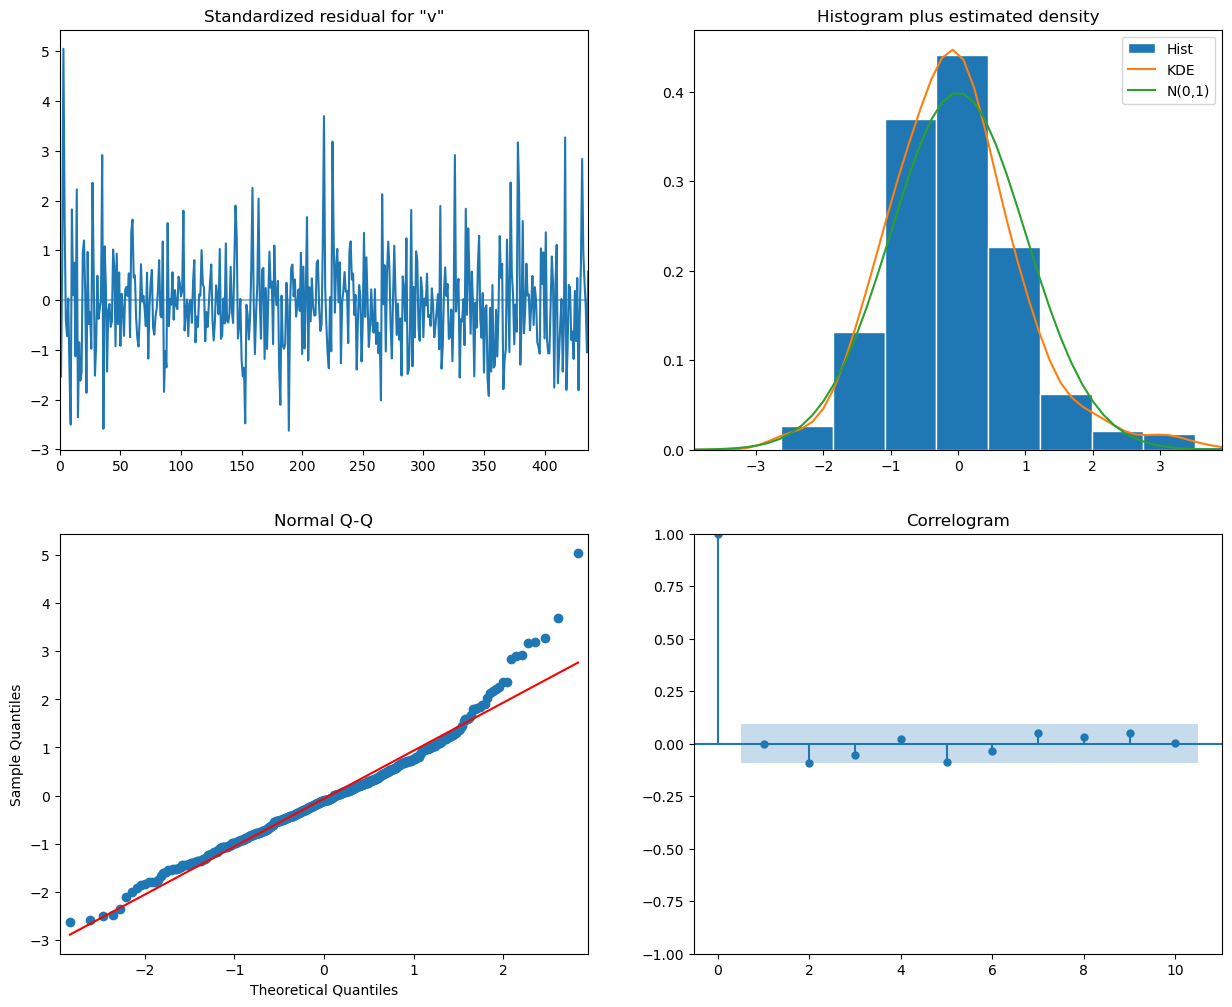

In [28]:
results.plot_diagnostics(figsize=(15,12))
plt.show()